# Couple a simple single column model to the RRTMG scheme and explore ECS

The thermal structure of the atmosphere is assumed to follow the pseudoadiabatic lapse rate in the troposphere, with an overlying isothermal stratosphere at a fixed tropopause temperature, following Seeley and Jeevanjee (2020).

In [68]:
%matplotlib inline 
import climlab

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt

import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [69]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

params.RH = 0.8

In [70]:
# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T):
    return np.divide(params.params.R_a, cp_a)


def custom_adiabat(T,p,beta):
    return beta*climlab.utils.thermo.pseudoadiabat(T, p) + (1-beta)*np.divide(params.R_a, params.cp_a)


def generate_idealized_temp_profile(SST, Tstrat, plevs, beta=1):
    solution = sp.odeint(custom_adiabat, SST, np.flip(plevs), args=(beta,))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

In [71]:
def calc_olr(SST, CO2ppmv, beta):
    ## RRTMG
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, params.Tstrat, plevs, beta)

    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=beta)

    # RRTMG radiation
    rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, 
                                  albedo=0.3, ozone_file=None, 
                                  return_spectral_olr=True, 
                                  absorber_vmr = {'CO2':CO2ppmv/1e6,
                                                  'CH4':0.,
                                                  'N2O':0.,
                                                  'O2':0.,
                                                  'CFC11':0.,
                                                  'CFC12':0.,
                                                  'CFC22':0.,
                                                  'CCL4':0.,
                                                  'O3':0.})
    rad.compute_diagnostics()
    olr = rad.OLR
    return olr, rad.OLR_sr

In [72]:
OLR0, OLR0_sr = calc_olr(SST=288,CO2ppmv=280, beta=1)
OLR0

Field([251.11282623])

In [6]:
OLR0_sr.sum()

Field(251.09324631)

In [7]:
central_rrtmg_lw_bands = np.array([180,425,565,665,760,900,
                                   1030,1130,1285,1435,1640,
                                   1940,2165,2315,2490,2925])

In [8]:
#([10-350, 350-500, 500-630, 630-700, 700-820, 820-980, 980-1080, 1080-1180, 1180-1390, 1390-1480, 1480-1800, 1800-2080, 2080-2250, 2250-2380, 2380-2600, 2600-3250])

In [9]:
delwave = np.array([340, 150, 130, 70, 120, 160,
                    100, 100, 210, 90, 320, 280,
                    170, 130, 220, 650])

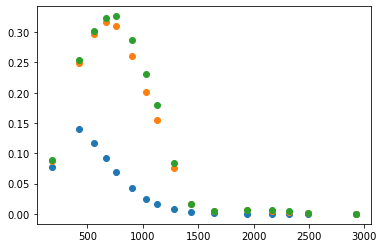

In [11]:
fig, ax = plt.subplots()

ax.scatter(central_rrtmg_lw_bands, calc_olr(SST=200,CO2ppmv=0, beta=1)[1]/delwave)
ax.scatter(central_rrtmg_lw_bands, calc_olr(SST=280,CO2ppmv=0, beta=1)[1]/delwave)
ax.scatter(central_rrtmg_lw_bands, calc_olr(SST=290,CO2ppmv=0, beta=1)[1]/delwave)

In [12]:
OLRS = np.zeros((30,30))

for idx1, temp in enumerate(np.linspace(280, 290, 30)):
    for idx2, co2 in enumerate(np.linspace(280, 1200, 30)):
        OLRS[idx1, idx2],_ = calc_olr(temp, co2, beta=1)

/home/users/andreww/miniconda3/envs/ecsbump/lib/python3.7/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)


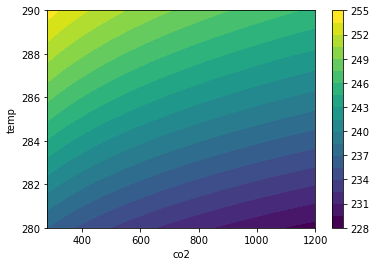

In [13]:
da=xr.DataArray(OLRS, dims=['temp', 'co2'], coords={'temp':np.linspace(280, 290, 30), 'co2':np.linspace(280, 1200, 30)})
da.plot.contourf(levels=20)

# Calculate C-T$_{s}$ curve using RRTMG scheme

Loop over temperatures, and for each temperature then increment the CO$_{2}$  in 1ppmv intervals until the TOA LW energy budget is closed to within 0.2 Wm$^{-2}$ of its original value, OLR$_{0}$. 

In [33]:
"""
The loop to calculate the C-Ts curve takes ~10 minutes to run on a laptop with 
the RRTMG scheme, so you can either choose to run it or just set run_loop=False
and then it will load the data from the Data folder
"""

run_loop = False

In [51]:
np.round(np.linspace(0.8, 1, 21),2)

array([0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ,
       0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [84]:
%%time

TEMPS = np.linspace(280, 335, 56)
BETAS = np.round(np.linspace(0.78, 1, 23),2) #np.array([0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1])
CO2_arr = np.zeros((len(TEMPS),len(BETAS)))

# Trial just having ONE baseline OLR0...
OLR0, OLR0_sr = calc_olr(SST=288,CO2ppmv=280, beta=1)

for beta_idx, beta in enumerate(BETAS):
    print(f"Doing beta={beta}")
    
    # Need a new baseline OLR for each beta!
    #OLR0, OLR0_sr = calc_olr(SST=288,CO2ppmv=280, beta=beta)
    co2_init = 1
    for temp_idx,sst in enumerate(TEMPS):

        if temp_idx==0:
            co2_trial=co2_init

        olr, olr_sr = calc_olr(SST=sst,CO2ppmv=co2_trial, beta=beta)

        imbalance = (olr-OLR0)[0]

        while np.abs(imbalance)>0.1:

            F2x=5
            co2_trial=co2_trial * np.power(2, imbalance/F2x) 

            olr, olr_sr = calc_olr(SST=sst,CO2ppmv=co2_trial, beta=beta)

            imbalance = (olr-OLR0)[0]

        #print('Final:   ', 'SST=',int(sst), ', CO2=',int(co2_trial), ', TOA imbalance=',imbalance,' W/m2')
        CO2_arr[temp_idx, beta_idx] = int(co2_trial)


Doing beta=0.78
Doing beta=0.79
Doing beta=0.8
Doing beta=0.81
Doing beta=0.82
Doing beta=0.83
Doing beta=0.84
Doing beta=0.85
Doing beta=0.86
Doing beta=0.87
Doing beta=0.88
Doing beta=0.89
Doing beta=0.9
Doing beta=0.91
Doing beta=0.92
Doing beta=0.93
Doing beta=0.94
Doing beta=0.95
Doing beta=0.96
Doing beta=0.97
Doing beta=0.98
Doing beta=0.99
Doing beta=1.0
CPU times: user 2min 17s, sys: 164 ms, total: 2min 18s
Wall time: 2min 18s


In [106]:
C_Ts_beta = xr.DataArray(CO2_arr, dims=['Ts', 'beta'], 
                    coords={'Ts':xr.DataArray(TEMPS, dims=['Ts'], attrs={'units':'K'}), 'beta':xr.DataArray(BETAS, dims=['beta'])},
                    attrs={'standard_name': 'CO$_{2}$', 'units': 'ppmv'})

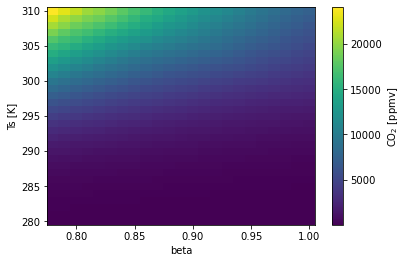

In [107]:
C_Ts_beta.sel(Ts=slice(280, 310)).plot()

In [87]:
da_ECS_2d = C_Ts_beta.copy()

In [88]:
for beta in da_ECS_2d.beta:
    Ts_C = xr.DataArray(TEMPS, dims=['CO2'], 
                        coords={'CO2':xr.DataArray(C_Ts_beta.sel(beta=beta).values, dims=['CO2'], attrs={'units':'ppmv'})},
                        attrs={'standard_name': 'Ts', 'units': 'K'})
    
    for temp in da_ECS_2d.Ts:
        conc = C_Ts_beta.sel(Ts=temp, beta=beta)
        #print(conc)
        da_ECS_2d.loc[dict(Ts=temp, beta=beta)] = Ts_C.interp(CO2=2*conc) - Ts_C.sel(CO2=conc)     
    

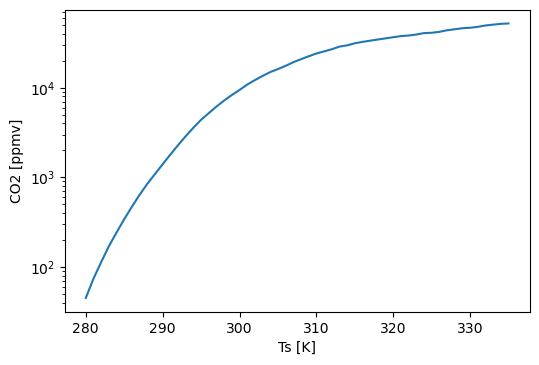

In [90]:
Ts_C = xr.DataArray(TEMPS, dims=['CO2'], 
                        coords={'CO2':xr.DataArray(C_Ts_beta.sel(beta=0.78).values, dims=['CO2'], attrs={'units':'ppmv'})},
                        attrs={'standard_name': 'Ts', 'units': 'K'})

fig, ax = plt.subplots(dpi=100)
Ts_C.plot(ax=ax, y='CO2')
ax.set_yscale('log')

In [12]:
import seaborn as sns
pal = sns.color_palette()

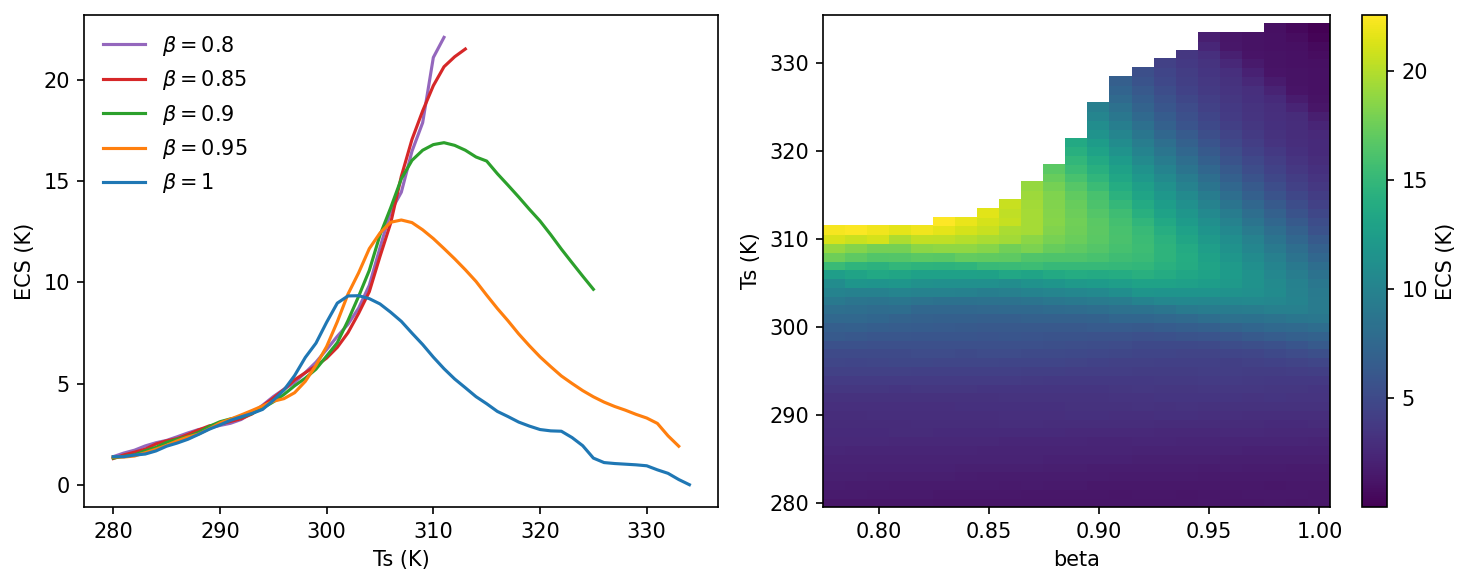

In [91]:
fig, ax = plt.subplots(ncols=2, dpi=150, figsize=(10,4))

da_ECS_2d.sel(beta=0.8).plot(ax=ax[0], color=pal[4], label=fr'$\beta=$0.8')
da_ECS_2d.sel(beta=0.85).plot(ax=ax[0], color=pal[3], label=fr'$\beta=$0.85')
da_ECS_2d.sel(beta=0.9).plot(ax=ax[0], color=pal[2], label=fr'$\beta=$0.9')
da_ECS_2d.sel(beta=0.95).plot(ax=ax[0], color=pal[1], label=fr'$\beta=$0.95')
da_ECS_2d.sel(beta=1).plot(ax=ax[0], color=pal[0], label=fr'$\beta=$1')
ax[0].set_ylabel("ECS (K)")
ax[0].set_xlabel("Ts (K)")
ax[0].legend(frameon=False, loc='upper left')
ax[0].set_title("")
#ax[0].legend([r'$\beta=1$', r'$\beta=0.975$', r'$\beta=0.95$', r'$\beta=0.925$', r'$\beta=0.9$', r'$\beta=0.875$', r'$\beta=0.85$', r'$\beta=0.825$', r'$\beta=0.8$'],
#             frameon=False, loc='upper left')

p=da_ECS_2d.plot(ax=ax[1],add_colorbar=False)

cb = fig.colorbar(p)
cb.set_label("ECS (K)")
ax[1].set_ylabel("Ts (K)")
fig.tight_layout()

#plt.savefig("./ecs_change_ts_and_beta.jpg", dpi=400, facecolor='white', bbox_inches='tight')

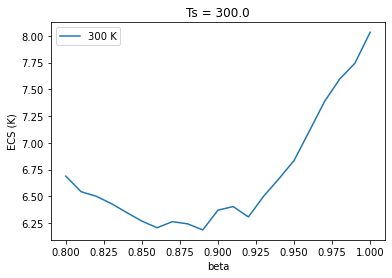

In [80]:
#da_ECS_2d.sel(Ts=290).plot(label='290 K')
#da_ECS_2d.sel(Ts=295).plot(label='295 K')
da_ECS_2d.sel(Ts=300).plot(label='300 K')
#da_ECS_2d.sel(Ts=305).plot(label='305 K')
plt.ylabel("ECS (K)")
plt.legend()

Text(0, 0.5, 'ECS (K)')

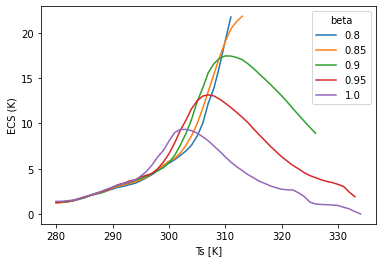

In [15]:
da_ECS_2d.plot(hue='beta')
plt.ylabel("ECS (K)")

### Calculate decomposition into F$_{2x}$ and $\lambda_{eff}$

$$\mathrm{F}_{2x}= \mathrm{OLR}(\mathrm{T}_{s}, \mathrm{C}) - \mathrm{OLR}(\mathrm{T}_{s}, 2*\mathrm{C})$$

$$\lambda_{\mathrm{eff}} = \frac{\mathrm{OLR}(\mathrm{T}_{s}+1, \mathrm{C}) - \mathrm{OLR}(\mathrm{T}_{s}, \mathrm{C})}{1\mathrm{K}}$$ 

In [104]:
da_F2x = C_Ts_beta.copy()
da_F2x.attrs = {'standard_name':'CO2_F2x', 'units': 'W/m2'}
#da_F2x

In [120]:
for beta in da_F2x.beta:
    for temp in da_F2x.Ts:
        conc = C_Ts_beta.sel(Ts=temp, beta=beta)
        da_F2x.loc[dict(Ts=temp.values, beta=beta.values)] = calc_olr(SST=temp.values,CO2ppmv=conc.values, beta=beta.values)[0][0] - calc_olr(SST=temp.values,CO2ppmv=conc.values*2, beta=beta.values)[0][0]
    

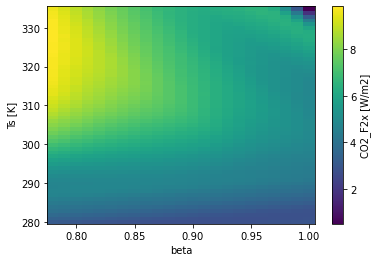

In [121]:
da_F2x.plot()

In [122]:
da_lambda = C_Ts_beta.copy()
da_lambda.attrs = {'standard_name':'Feedback_parameter', 'units': 'W/m2/K'}
#da_lambda

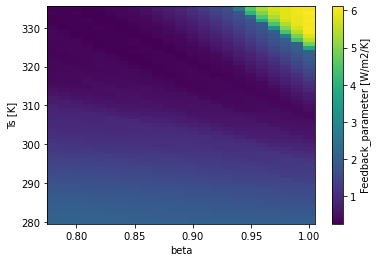

In [125]:
for beta in da_F2x.beta:

    for temp in da_lambda.Ts:
        conc = C_Ts_beta.sel(Ts=temp, beta=beta)
        da_lambda.loc[dict(Ts=temp, beta=beta)] = calc_olr(SST=temp.values+1,CO2ppmv=conc.values, beta=beta.values)[0][0] - calc_olr(SST=temp.values,CO2ppmv=conc.values, beta=beta.values)[0][0]
    

da_lambda.plot()

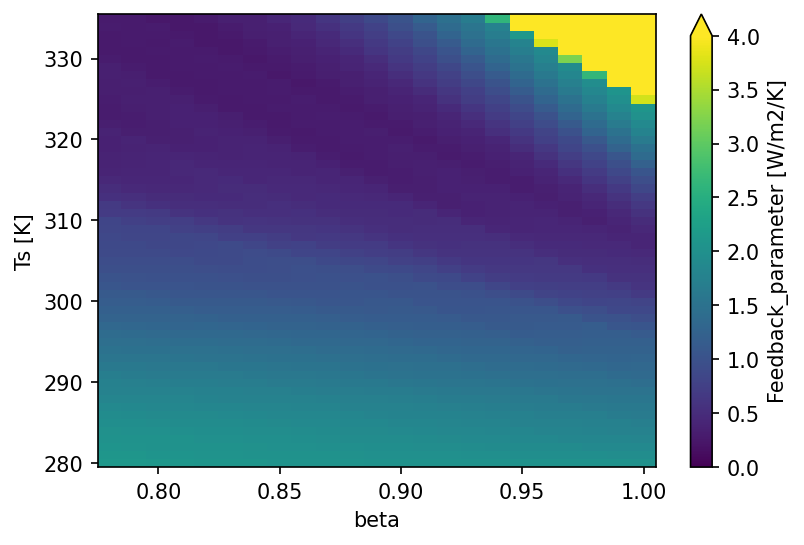

In [130]:
fig = plt.figure(dpi=150)

da_lambda.plot(vmin=0, vmax=4)

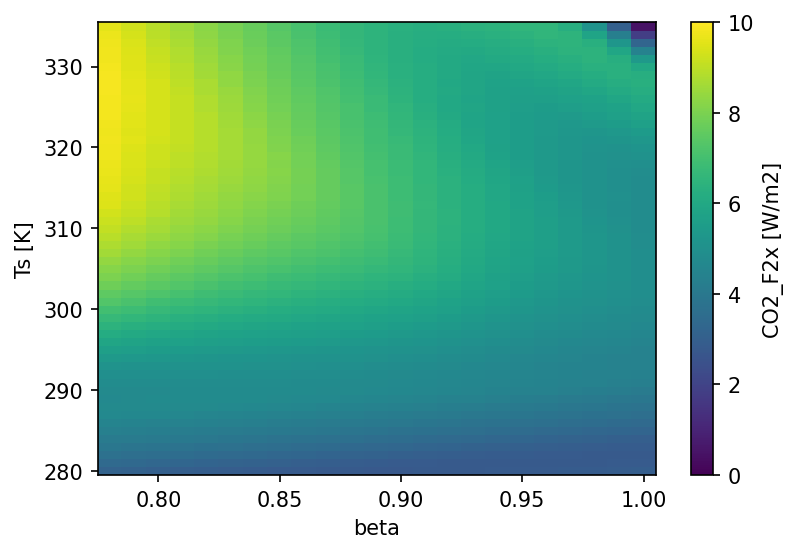

In [134]:
fig = plt.figure(dpi=150)

da_F2x.plot(vmin=0, vmax=10)

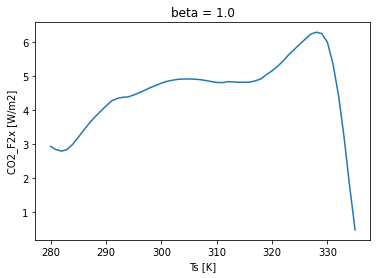

In [136]:
da_F2x.sel(beta=1).plot()

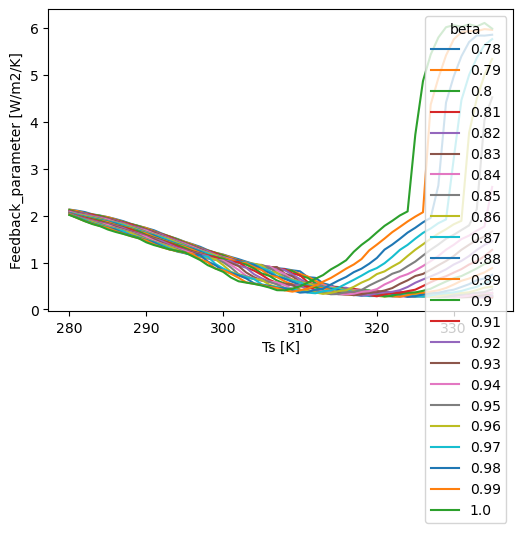

In [135]:
fig = plt.figure(dpi=100)
_=da_lambda.plot(hue='beta')

In [143]:
def _colorbar_axis(ax):
    """
    Uses inset_axes to add a vertical colorbar to the right of your plot
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(ax, width="5%",height="100%",
                       loc='lower left',bbox_to_anchor=(1.05, 0.00, 1, 1),
                       bbox_transform=ax.transAxes,borderpad=0)
    return axins

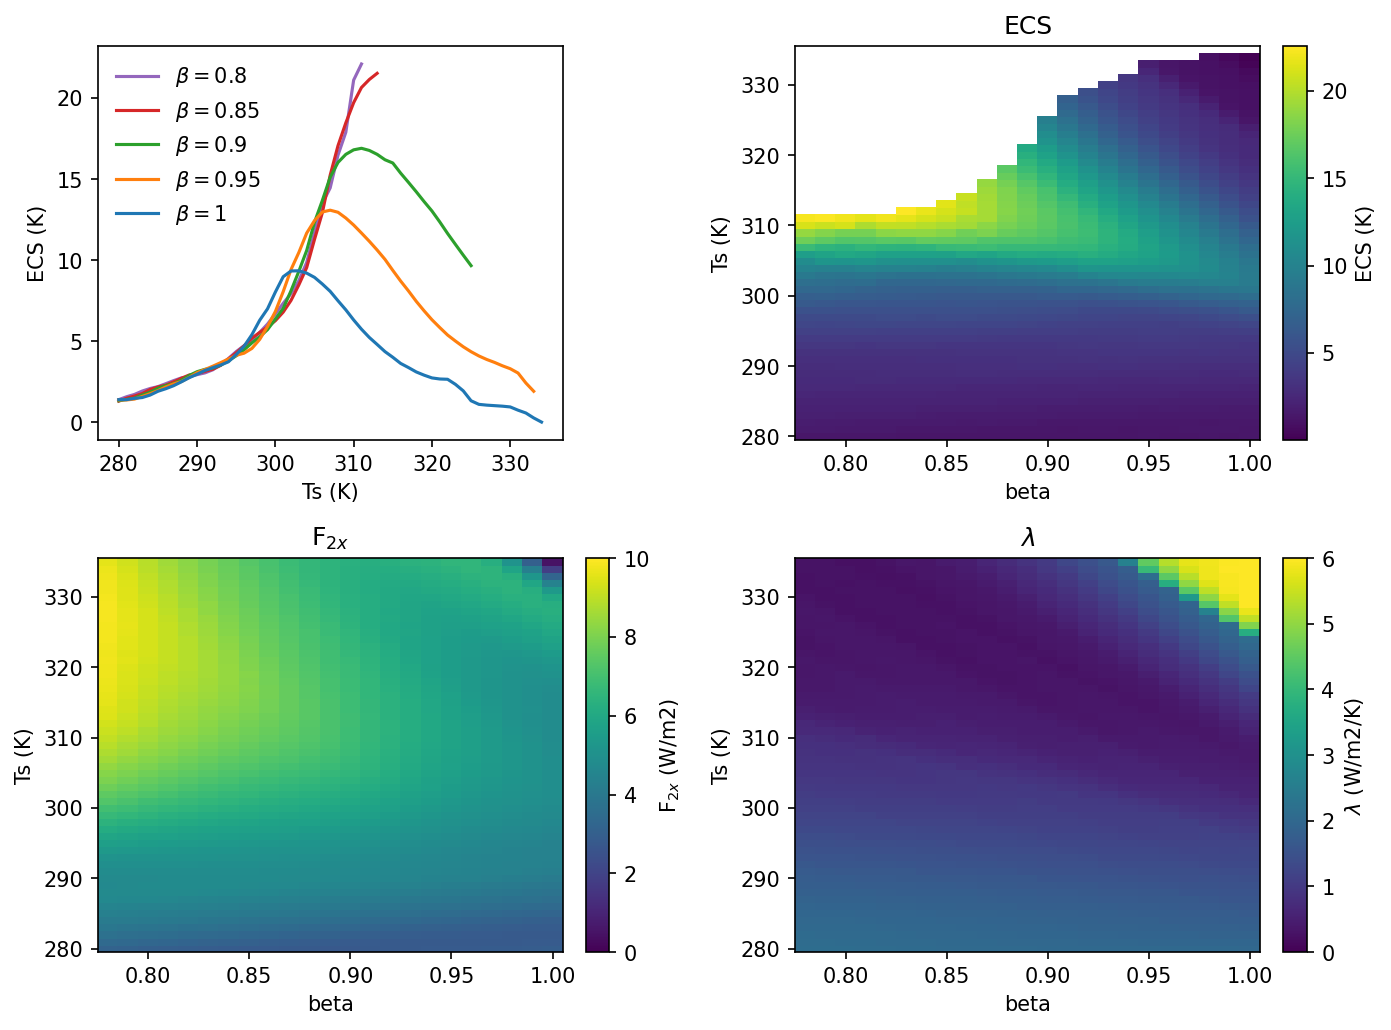

In [160]:
fig, ax = plt.subplots(ncols=2, nrows=2, dpi=150, figsize=(10,8))

da_ECS_2d.sel(beta=0.8).plot(ax=ax[0,0], color=pal[4], label=fr'$\beta=$0.8')
da_ECS_2d.sel(beta=0.85).plot(ax=ax[0,0], color=pal[3], label=fr'$\beta=$0.85')
da_ECS_2d.sel(beta=0.9).plot(ax=ax[0,0], color=pal[2], label=fr'$\beta=$0.9')
da_ECS_2d.sel(beta=0.95).plot(ax=ax[0,0], color=pal[1], label=fr'$\beta=$0.95')
da_ECS_2d.sel(beta=1).plot(ax=ax[0,0], color=pal[0], label=fr'$\beta=$1')
ax[0,0].set_ylabel("ECS (K)")
ax[0,0].set_xlabel("Ts (K)")
ax[0,0].legend(frameon=False, loc='upper left')
ax[0,0].set_title("")
#ax[0].legend([r'$\beta=1$', r'$\beta=0.975$', r'$\beta=0.95$', r'$\beta=0.925$', r'$\beta=0.9$', r'$\beta=0.875$', r'$\beta=0.85$', r'$\beta=0.825$', r'$\beta=0.8$'],
#             frameon=False, loc='upper left')

p=da_ECS_2d.plot(ax=ax[0,1],add_colorbar=False)

cb = fig.colorbar(p, cax=_colorbar_axis(ax[0,1]))
cb.set_label("ECS (K)")
ax[0,1].set_ylabel("Ts (K)")
ax[0,1].set_title("ECS")

p=da_F2x.plot(ax=ax[1,0],add_colorbar=False, vmin=0, vmax=10)

cb = fig.colorbar(p, cax=_colorbar_axis(ax[1,0]))
cb.set_label("F$_{2x}$ (W/m2)")
ax[1,0].set_ylabel("Ts (K)")
ax[1,0].set_title("F$_{2x}$ ")


p=da_lambda.plot(ax=ax[1,1],add_colorbar=False, vmin=0, vmax=6)

cb = fig.colorbar(p, cax=_colorbar_axis(ax[1,1]))
cb.set_label("$\lambda$ (W/m2/K)")
ax[1,1].set_ylabel("Ts (K)")
ax[1,1].set_title("$\lambda$")

fig.subplots_adjust(wspace=0.5, hspace=0.3)

#plt.savefig("./ecs_change_ts_and_beta_forcingfeedback.jpg", dpi=400, facecolor='white', bbox_inches='tight')